In [ ]:
import sys
import numpy as np
from pathlib import Path
from pyPolCal.csv_tools import read_csv,read_csv_physical_model_all_bins
from pyPolCal.fitting import *
from pyPolCal.utils import *
from pyPolCal.plotting import plot_data_and_model
from pyMuellerMat.physical_models.charis_physical_models import *
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import pandas as pd
# Plot settings that I like
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "serif",
   # "font.serif": ["Palatino"],
    "font.size": 16,
   # "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathpazo}"
})
from pyPolCal.constants import wavelength_bins


NameError: name 'charis_aperture_l' is not defined

# Step 1: Write FITS Info to CSV

This CSV writer will organize all relevant header information. Some header information is excluded from the extracted cubes but exists in the raw files. This function will match the info from raw headers by matching tags in the filenames. The CHARIS DPP rewrites these tags, so if you used the DPP at any point you will need to retitle all the frames to their original titles (there is a function in csv_tools.py to do this).

In [5]:
# Get paths to both processed and raw data 
# Make sure these directories have cubes with corresonding numbers
cube_dir = '/home/thomasmc/nbs_in/pol/cubes'
raw_dir = '/home/thomasmc/nbs_in/pol/raw'
csv_dir = '/home/thomasmc/nbs_in/pol/csvs'

# Write all bins to csvs
for bin in range(0,22):
   csv_filepath = f'/home/thomasmc/nbs_in/pol/csvs/bin{bin}.csv'
   write_fits_info_to_csv(cube_dir, raw_dir, csv_filepath,bin)



CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin0.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin1.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin2.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin3.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin4.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin5.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin6.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin7.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin8.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin9.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin10.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin11.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin12.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin13.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin14.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin15.csv
CSV file written to /home/thomasmc

# Step 2 (Optional): Plot Your Data With the Original Model 

The csv reader will read in `interleaved_values`: interleaved single differences and sums `[differences, sums...]`, `interleaved_stds`:poissan noise propagated standard deviations (which are not used anymore and is an artifact of old code), and a `configuration_list` of dictionaries where each dictionary represents the instrument configuration for a measurement. The rationale for assuming no noise is that it is so tiny when normalized over large numbers of pixels it is irrelevant. It also improves fit accuracy.

In [2]:
# Define a csv filepath that we just created from whatever wavelength bin you want to visualize
# Weird things happen at the very lowest bins, so I recommend something more in the middle
filepath = Path('../datacsvs/nbs_in_internalcal_csvs/bin15.csv')
# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

NameError: name 'read_csv' is not defined

The Mueller matrix chain is contained in a pyMuellerMat system Mueller matrix object. These are generated using configuration dictionaries with the below format. You can generate a system dictionary with any function listed in the common_mm_functions.py script in the pyMuellerMat physical_models branch (can be found here: https://github.com/maxwellmb/pyMuellerMat/tree/physical_models/pyMuellerMat). Each component is within a `components` dictionary, listed from downstream to upstream. You can name each component, and give it a `type` which is the name of the commmon mm function. The `properties` are the case sensitive inputs to these functions. Tag each component as `internal`. With this system dict you can create your Mueller matrix with `generate_system_mueller_matrix()`.

In [19]:

# Loading in past fits 

offset_imr = 0.18563 # derotator offset
offset_hwp = -0.87823 # HWP offset
offset_cal = -0.44630 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0



# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            'nbs_rot' : {
                "type" : "rotator_function",
                "properties" : {'pa':90},
                "tag": "internal",
            },
            "image_rotator" : {
                "type" : "elliptical_retarder_function",
                "properties" : {"phi_h": 1, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "diattenuator_retarder_function",
                "properties": {"epsilon": 1, "delta_theta": offset_cal},
                "tag": "internal"},
            
        }}
    

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
evaluated_mm = system_mm.evaluate()
s_in = [1,0,0,0]
s_out = evaluated_mm @ s_in
print(s_out)



[9.3523637e-05 9.3523637e-05 0.0000000e+00 0.0000000e+00]


Here is where we can load in our old fit. The fit I have loaded in is my median posterior MCMC fit of the Joost 't Hart 2021 physical model. The physical model is contained in functions from the physical_models branch of pyMuellerMat. The fit is not very good, which prompted the switch to an elliptical polarizer model for the derotator. `p` and `system_parameters` are updates that will be placed into the Mueller matrix. This is because plotting function is made to use the same workflow as `minimize_system_mueller_matrix()` (If you would prefer to work without my wrapper function, follow the same procedure here to generate the model).

`p` is the float values of the parameters detailed in `system_parameters` which contains the float value's component name and what `property` it is in the `system_dict`. `modeled_interleaved` are the modeled single sums and differences generated from the `system_mm` and updated p values, which we then process into double sums and differences using `process_model()`. Note that, for CHARIS, the sums are irrelevant. `plot_data_and_model()` plots the double differences vs. HWP angle for all derotator angles. 

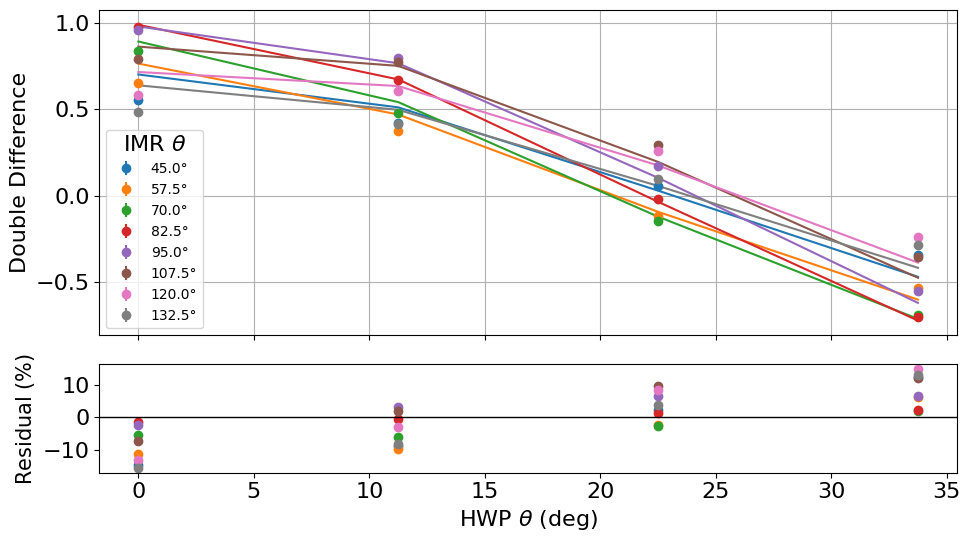

[ 0.70063934  0.51065218  0.02914551 -0.46914475  0.76358019  0.46917788
 -0.09318304 -0.60069706  0.89122178  0.54092146 -0.12138718 -0.71240423
  0.98792253  0.67216791 -0.03541066 -0.72217305  0.97814385  0.76558572
  0.10318718 -0.61970912  0.86162597  0.75043105  0.1952364  -0.47449264
  0.7149313   0.63383918  0.17483442 -0.38683758  0.63799825  0.4964186
  0.05645473 -0.41686807]
[np.float64(3.0570640046313304), np.float64(0.8357196966340271)] [['hwp', 'phi'], ['image_rotator', 'phi_h']]


In [20]:

# Get our model retardances from Joost t Hart physical models

p = [HWP_retardance(wavelength_bins,1.66725,1.30159)[15], IMR_retardance(wavelength_bins,259.14673)[15]]


# Define what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi_h']]

# Generate our modeled left and right beam intensities

modeled_interleaved = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(modeled_interleaved)

# Plot the modeled and observed values

fig, ax = plot_data_and_model(interleaved_values, diffs_sums,configuration_list, wavelength= wavelength_bins[15],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1932.png',bbox_inches='tight', dpi=600)
diffs = process_dataset(interleaved_values)[::2]
print(diffs_sums[::2])
pol_acc = np.sqrt(np.sum((diffs*100-diffs_sums[::2]*100)**2)/(len(diffs)-6))
pol_acc
print(p, system_parameters)

# Step 3: Fit for Retardances

ABOUT THE FITTING FUNCTION/HOW I USE IT: I made a function that does everything quickly but is also tailored to the parameters I am fitting. My function fits using scipy least squares, updates the model, puts the pyMuellerMat compatible system dictionary in a JSON file, and optionally saves a plot of the model vs data to a specified path.
If you want to use it for different parameters than the ones in the p0 dictionary within the function, 
you'll have to update the function a bit (which shouldn't take too long). This is a wrapper function for the main minimization function in fitting.py. I've found it easier to use this function and tailor the parameters that it's fitting to what I need instead of using that fitting function. The things you need to edit in this function in instruments.py to fit new parameters are marked with all caps comments that look like this: # IF YOU WANT TO MODIFY YOUR PARAMETERS, EDIT THIS

This funciton calculates s_res, which is a metric used in previous polcal papers to quantify goodness of fit. It's essentially a corrected average of residuals. It also calculates error on fit from a Jacobian estimation technique from Rob Van Holstein's 2020 VLT SPHERE polcal paper.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.7047e+00                                    3.00e+01    
       1              2         4.6095e+00      4.10e+00       9.31e-01       1.35e+00    
       2              3         4.1086e+00      5.01e-01       3.13e-01       3.65e-01    
       3              4         3.9752e+00      1.33e-01       2.66e-01       2.69e-01    
       4              5         3.8803e+00      9.49e-02       2.31e-01       3.12e-01    
       5              6         3.8546e+00      2.58e-02       8.56e-02       3.64e-01    
       6              7         3.8496e+00      4.95e-03       1.00e-01       3.37e-02    
       7              8         3.8445e+00      5.10e-03       1.73e-02       4.21e-02    
       8              9         3.8443e+00      2.53e-04       6.35e-03       5.20e-03    
       9             10         3.8442e+00      1.20e-04       2.35e-03       4.20e-03    

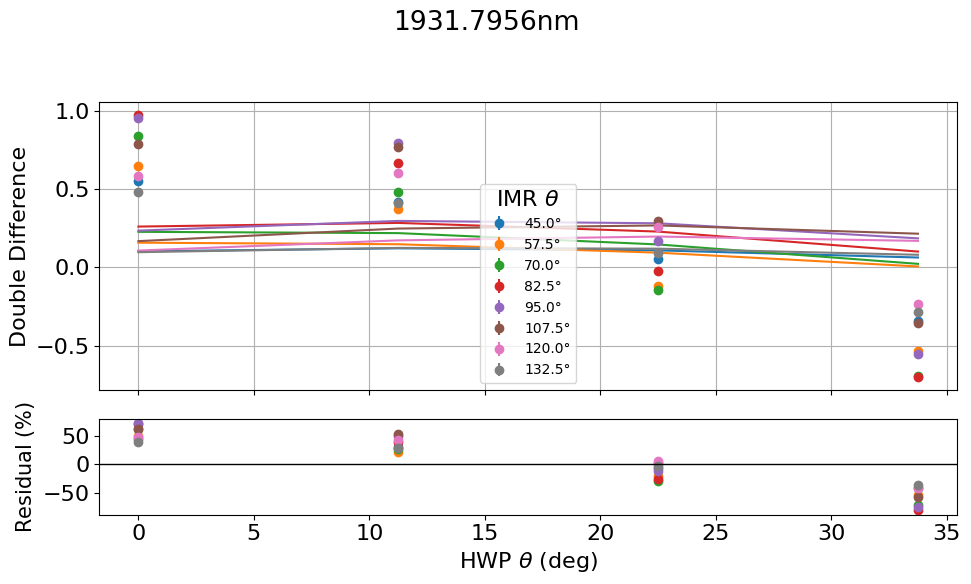

Updated Mueller Matrix:
[[ 0.03287015  0.03287015  0.          0.        ]
 [-0.00070801 -0.00070801  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -80.09132144727269 72.0263972231387
s_res: 49.96735091525938
Error: [0.3386434  0.32003069 0.38944165 0.         0.12598377]


/tmp/ipykernel_1853440/139288076.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


In [3]:
# Test fitting with the wavelength bin we plotted earlier
from pyPolCal.instruments import fit_CHARIS_Mueller_matrix_by_bin_nbs
error, fig2, ax2,sres = fit_CHARIS_Mueller_matrix_by_bin_nbs(filepath, 15, 
    Path('/home/thomasmc/nbs_in/pol/sys_dicts/test.json'),
    )
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()
fig2.suptitle('')
fig2.show()
#fig2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/naive_model_single_diff_vs_hwp_1932.png',bbox_inches='tight', dpi=600)



The elliptical IMR model is a huge improvement! Now we can fit for all bins. In this fit, I'm fitting for 3 elliptical retarder parameters and a Wollaston prism modulator term.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.7893e+00                                    8.13e+00    
       1              2         3.6164e+00      2.17e+00       5.82e-01       3.48e+00    
       2              3         3.2577e+00      3.59e-01       4.80e-01       1.37e+00    
       3              4         3.1767e+00      8.10e-02       6.37e-01       1.69e+00    
       4              5         3.1328e+00      4.38e-02       1.75e-01       5.12e-01    
       5              6         3.1016e+00      3.13e-02       2.17e-01       1.24e+00    
       6              8         3.0795e+00      2.20e-02       4.43e-02       1.26e+00    
       7              9         3.0696e+00      9.88e-03       6.91e-02       2.36e-01    
       8             10         3.0618e+00      7.87e-03       1.15e+00       7.52e-02    
       9             11         3.0617e+00      5.95e-05       1.52e+00       7.27e-05    

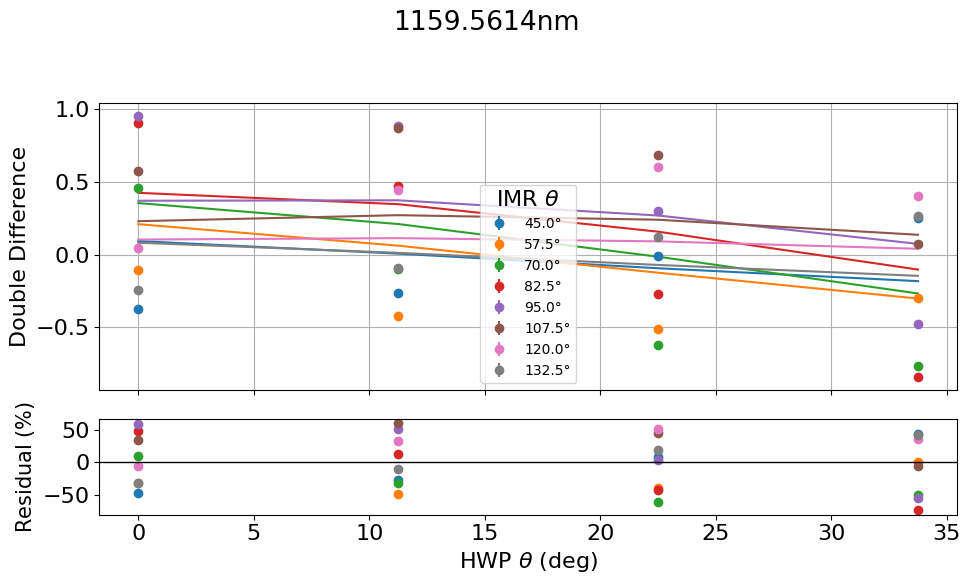

Updated Mueller Matrix:
[[ 0.03425342  0.03425342  0.          0.        ]
 [-0.01561755 -0.01561755  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -73.90182172396193 59.69026321076117
s_res: 43.345385848363854
Error: [0.1946823  0.53460178 0.63210576 0.         0.1299396 ]


FileNotFoundError: [Errno 2] No such file or directory: '../system_dictionaries/nbs_in_naive_test/bin0.json'

In [ ]:
# Fit all 22 wavelength bins
from pyPolCal.instruments import fit_CHARIS_Mueller_matrix_by_bin_nbs
from pathlib import Path
errors = []
sres_list = []
for bin in range(0,22):
    error,fig,ax,sres = fit_CHARIS_Mueller_matrix_by_bin_nbs(
        f'../datacsvs/nbs_in_internalcal_csvs/bin{bin}.csv',bin,
        Path(f'../system_dictionaries/nbs_in_naive/bin{bin}.json'),
    )
    errors.append(error)
    sres_list.append(sres)



In [9]:
# find average error
import numpy as np
errors = np.array(errors)
print('phi_h', np.mean(errors[:,0]))
print('phi_45',np.mean(errors[:,1]))
print('phi_r',np.mean(errors[:,2]))
print('wol_eta',np.mean(errors[:,3]))




    

phi_h 0.00791335941578012
phi_45 0.00954535167484431
phi_r 0.007962832859104232
wol_eta 0.0067706632877409445


Text(0.5, 1.0, 'Polarimetric Accuracy')

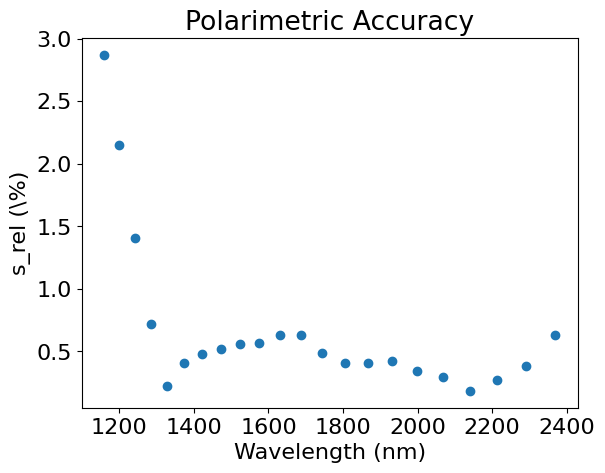

In [10]:
# LINEAR NAIVE HWP AND LINER DER NAIVE, DER ELLIP PHI_H STARTING GUESS
import matplotlib.pyplot as plt
plt.scatter(wavelength_bins,sres_list)
plt.xlabel('Wavelength (nm)')
plt.ylabel('s_rel (\%)')
plt.title('Polarimetric Accuracy')
#plt.savefig('/home/thomasmc/nbs_in/polcal_testing_2/plots/naive_linear_imr_scipy_physical_hwp_scipy_off.png')

`model_data` will list out all of your fits in a data frame.

In [11]:
from pyPolCal.csv_tools import model_data
json_dir = '../system_dictionaries/nbs_in_internalcal/'
df = model_data(json_dir, offsets=False)

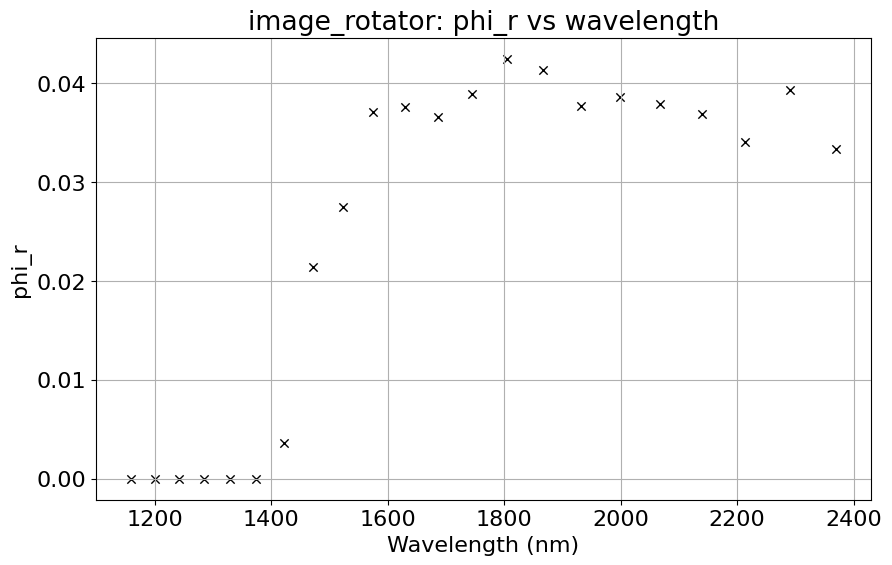

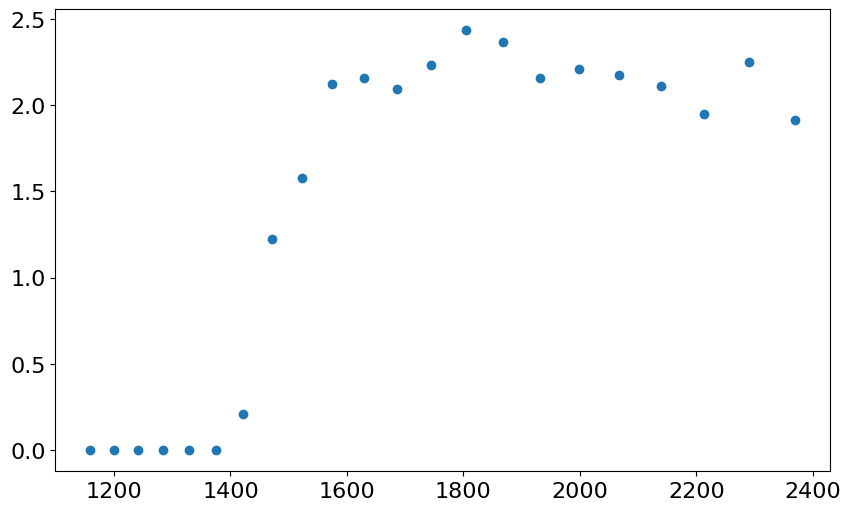

In [ ]:
# plot 45 degree linear retardance
from pyPolCal.plotting import plot_config_dict_vs_wavelength
params, fig, ax = plot_config_dict_vs_wavelength('image_rotator', 'phi_r', json_dir)
fig, ax = plt.subplots(figsize=(10,6))
# plot in degrees
ax.scatter(wavelength_bins, np.rad2deg(params))

# Step 4: Fit for Global Parameters

In [3]:
# Get interleaved values for all wavelength bins
csvdir = Path('../datacsvs/nbs_in_internalcal_csvs')

interleaved_values_all, interleaved_stds_all, configuration_list_all = read_csv_physical_model_all_bins(csvdir)

from pyPolCal.constants import wavelength_bins
wavelength_bin = 15 # placeholder
epsilon_cal = 1 # defining as perfect, reasoning in Joost t Hart 2021
offset_imr = -0.0018
offset_hwp = -0.0022 
offset_cal = -0.0315 
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits from scipy minimize on the naive fits
d = 259.7
wsio2 = 1.613
wmgf2 = 1.261

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
    "wollaston" : {
        "type" : "CHARIS_wollaston_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "beam": 'o'}, 
        "tag": "internal",
    },
            "nbs_rot": {
                "type": "rotator_function",
                "properties": {"pa": 90},
                "tag": "internal",
            },
    "image_rotator" : {
        "type" : "elliptical_IMR_function",
        "properties" : {"wavelength":wavelength_bins[wavelength_bin], "theta": imr_theta, "delta_theta": offset_imr},
        "tag": "internal",
    },
    "hwp" : {
        "type" : "two_layer_HWP_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
        "tag": "internal",
    },
    "lp" : {  # calibration polarizer for internal calibration source
        "type": "diattenuator_retarder_function",
        "properties": {"epsilon": epsilon_cal, "delta_theta": 0},
        "tag": "internal",
    }}
}
    
# Starting guesses

p0_dict = {
    "image_rotator" : 
        {"delta_theta": offset_imr},
    "hwp" :  
        {"w_SiO2": wsio2, "w_MgF2": wmgf2, "delta_theta": offset_hwp},
    "lp" : 
        {"delta_theta": offset_cal},
}

system_mm = generate_system_mueller_matrix(system_dict) # Generating pyMuellerMat system MM
print(system_mm.evaluate())
p0 = [1.623, 1.268, 262.56] # Starting guesses from Joost t Hart 2021 
offset_bounds = (-5,5) 
d_bounds = (0.8*p0[2], 1.2*p0[2]) # Physical parameters shouldn't have changed much
imr_offset_bounds = offset_bounds
wsio2_bounds = (0.6*p0[0], 1.4*p0[0])
wmgf2_bounds = (0.6*p0[1], 1.4*p0[1])
bounds=[offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
# Process everything into double differences and propagate errors





[[ 0.00844957  0.00844957  0.          0.        ]
 [-0.00416697 -0.00416697  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


In [4]:
# Minimize everything globally with minimize
from pyPolCal.fitting import minimize_system_mueller_matrix
result_min, logl_min=minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=bounds,mode='minimize')
print(result_min)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.18534833010956708
        x: [ 6.637e-03  1.638e+00  1.280e+00 -3.303e-02 -1.506e-02]
      nit: 20
      jac: [ 1.202e-02  8.187e-04 -9.359e-04  2.101e-03 -2.418e-03]
     nfev: 162
     njev: 27
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [5]:
# get errs
cov = result_min.hess_inv
errs = np.sqrt(np.diag(cov.todense()))
print("Errs:", errs)

Errs: [ 57.82650797  10.55035135   7.85644903 123.60426527  61.9709508 ]


# Step 5: Redo Derotator and Wollaston Fits with Global Parameters

I have to edit the wrapper function before doing this with the results of the scipy minimize fit.

/home/thomasmc/miniconda3/envs/charisenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2688e-02                                    9.99e-12    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 1.2688e-02, final cost 1.2688e-02, first-order optimality 9.99e-12.
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 1.521e-02  1.150e-02 ... -8.801e-03  1.897e-02]
           x: [ 1.000e+00]
        cost: 0.012688487221660773
         jac: [[-3.603e-01]
               [ 4.396e-02]
               ...
               [ 2.570e-01]
               [-5.898e-02]]
        grad: [-9.989e-02]
  optimality: 9.988911164362304e-12
 active_mask: [1]
        nfev: 1
        njev: 1
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2688e-02                                    9.99e-12    
`gtol` termination condit

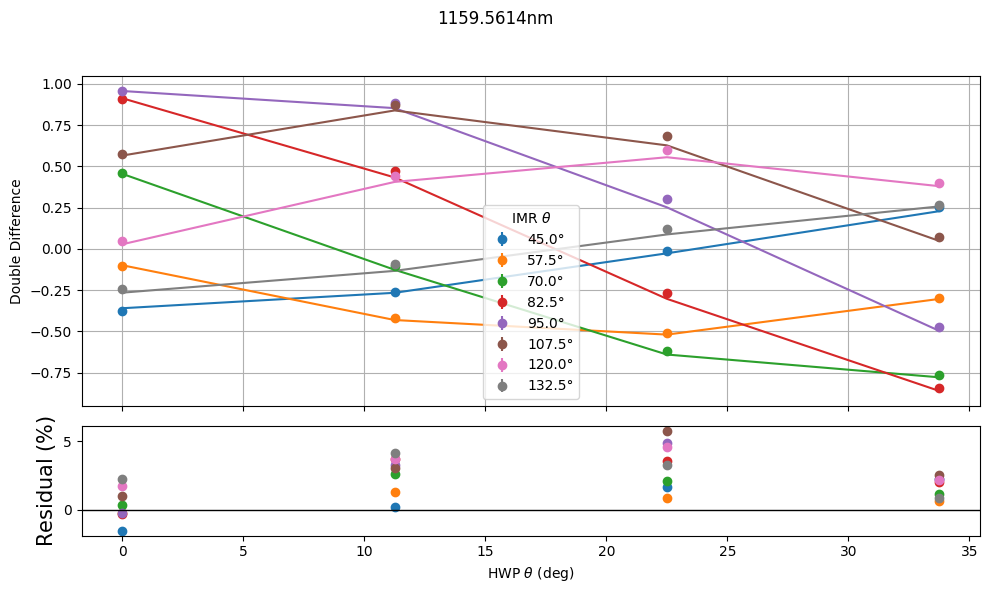

Updated Mueller Matrix:
[[ 3.42008934e-01  3.42008887e-01 -1.79791753e-04  0.00000000e+00]
 [-3.42008934e-01 -3.42008887e-01  1.79791753e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -1.521446122549996 5.777824597407175
s_res: 2.6813410648532794
Error: [0.00704514]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1979e-02                                    2.42e-04    
       1              2         1.1952e-02      2.67e-05       1.92e-03       3.66e-05    
       2              3         1.1951e-02      9.51e-07       4.16e-04       1.72e-06    
       3              4         1.1951e-02      2.33e-09       2.16e-05       4.63e-09    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 1.1979e-02, final cost 1.1951e-02, first-order optimality 4.63e-0

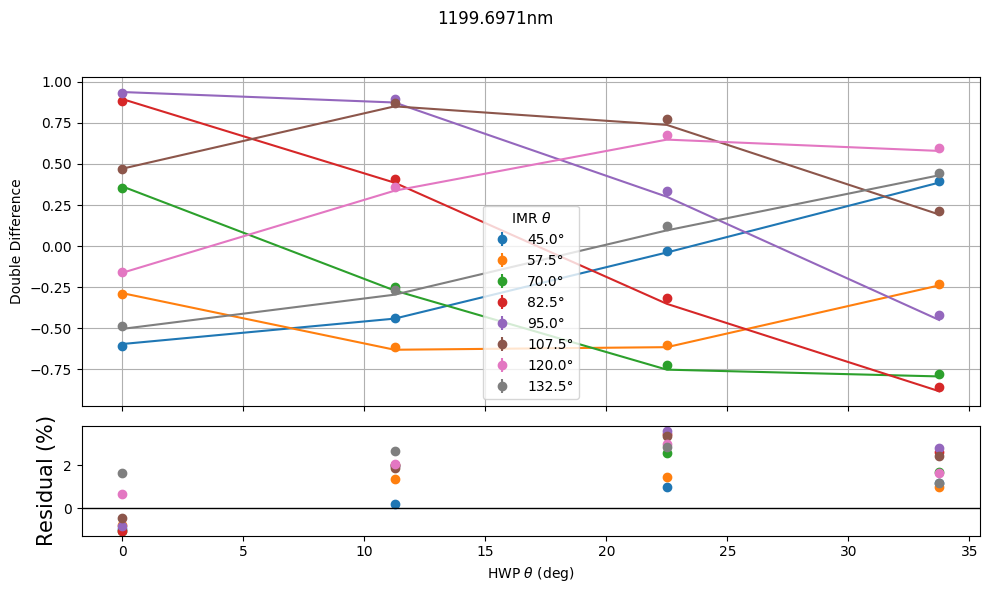

Updated Mueller Matrix:
[[ 2.55379017e-01  2.55378982e-01 -1.34250999e-04  0.00000000e+00]
 [-2.49430012e-01 -2.49429978e-01  1.31123648e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -1.024588335997592 3.5704877932494625
s_res: 2.0312160859383166
Error: [0.00617208]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6578e-03                                    4.91e-05    
       1              2         4.6544e-03      3.41e-06       6.73e-04       5.32e-06    
       2              3         4.6544e-03      5.28e-08       9.31e-05       1.02e-07    
       3              4         4.6544e-03      2.00e-11       1.85e-06       3.26e-11    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 4.6578e-03, final cost 4.6544e-03, first-order optimality 3.26e-

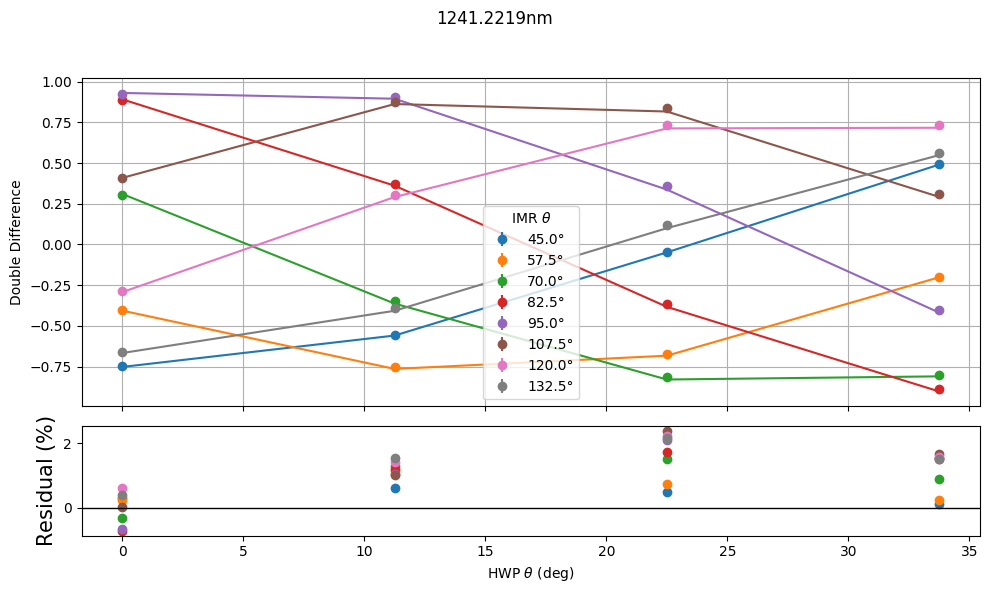

Updated Mueller Matrix:
[[ 1.97941058e-01  1.97941031e-01 -1.04056258e-04  0.00000000e+00]
 [-1.94178418e-01 -1.94178391e-01  1.02078264e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.7080838037952759 2.376769467125712
s_res: 1.2979742970683088
Error: [0.00354985]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.8415e-03                                    6.83e-02    
       1              2         4.6674e-03      1.74e-04       5.00e-03       3.45e-04    
       2              3         4.6674e-03      4.47e-09       2.55e-05       9.04e-09    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 4.8415e-03, final cost 4.6674e-03, first-order optimality 9.04e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      statu

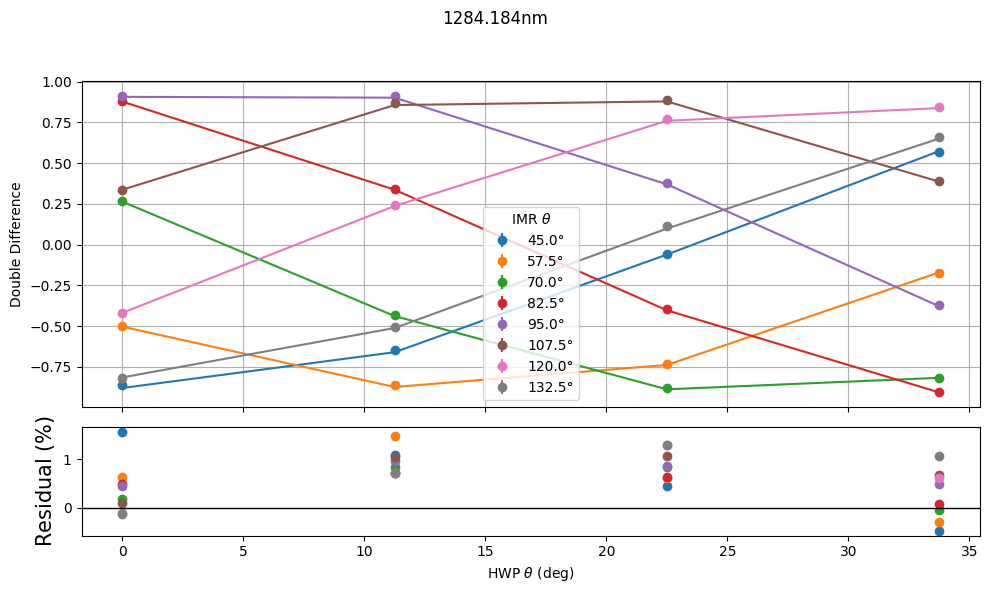

Updated Mueller Matrix:
[[ 1.52958811e-01  1.52958790e-01 -8.04093986e-05  0.00000000e+00]
 [-1.37291039e-01 -1.37291020e-01  7.21729583e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.4718473581179268 1.5560202770150369
s_res: 0.8088795664376504
Error: [0.00327881]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1031e-02                                    1.67e-01    
       1              2         1.0093e-02      9.38e-04       1.09e-02       1.84e-03    
       2              3         1.0093e-02      1.16e-07       1.23e-04       2.35e-07    
       3              4         1.0093e-02      1.88e-15       1.57e-08       2.65e-11    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 1.1031e-02, final cost 1.0093e-02, first-order optimality 2.65e

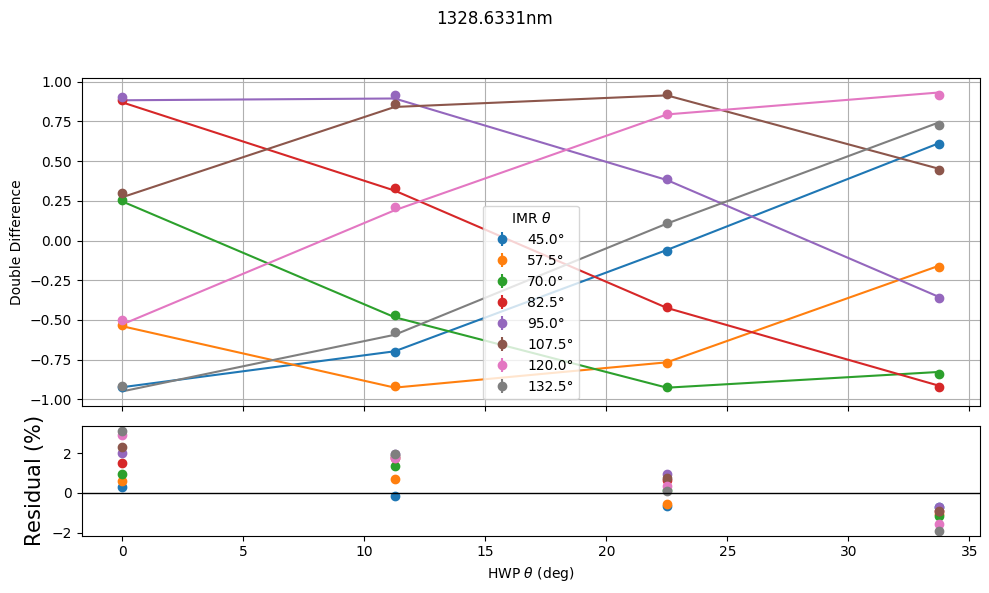

Updated Mueller Matrix:
[[ 1.35642211e-01  1.35642193e-01 -7.13061809e-05  0.00000000e+00]
 [-1.09407665e-01 -1.09407650e-01  5.75148598e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -1.902504351172965 3.1101581866848846
s_res: 1.4488076227492124
Error: [0.0045613]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.3484e-03                                    4.37e-04    
       1              2         4.3034e-03      4.50e-05       2.11e-03       6.32e-05    
       2              3         4.3020e-03      1.42e-06       4.30e-04       2.61e-06    
       3              4         4.3020e-03      2.67e-09       1.94e-05       5.31e-09    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 4.3484e-03, final cost 4.3020e-03, first-order optimality 5.31e-0

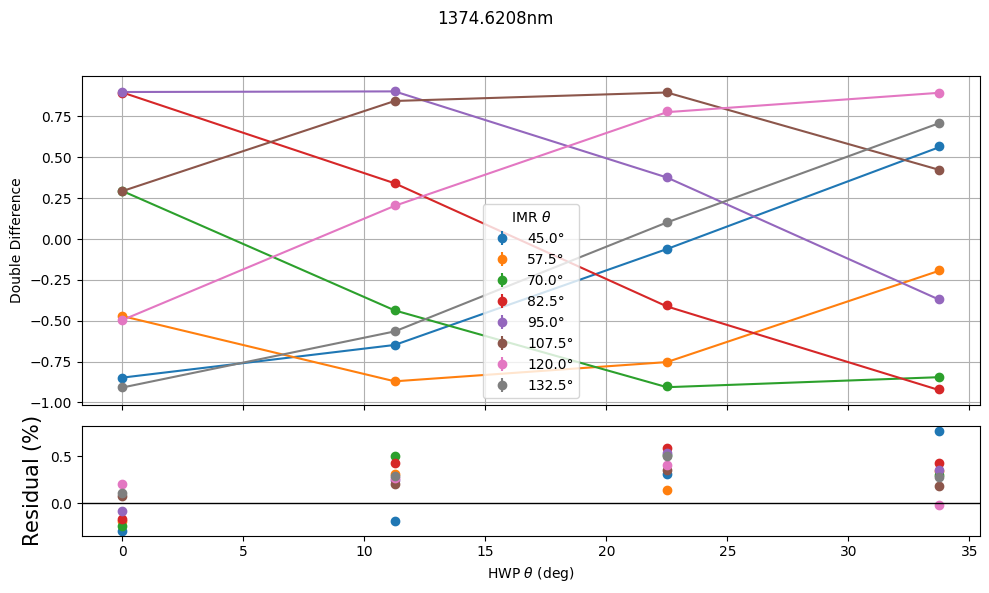

Updated Mueller Matrix:
[[ 1.64133365e-01  1.64133342e-01 -8.62837850e-05  0.00000000e+00]
 [-1.56166752e-01 -1.56166730e-01  8.20957911e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.29457714745402086 0.7696289245796208
s_res: 0.35442549717268085
Error: [0.00310851]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9403e-03                                    2.36e-04    
       1              2         3.9257e-03      1.46e-05       1.38e-03       2.33e-05    
       2              3         3.9255e-03      1.84e-07       1.70e-04       3.56e-07    
       3              4         3.9255e-03      4.42e-11       2.68e-06       8.73e-11    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 3.9403e-03, final cost 3.9255e-03, first-order optimality 8.7

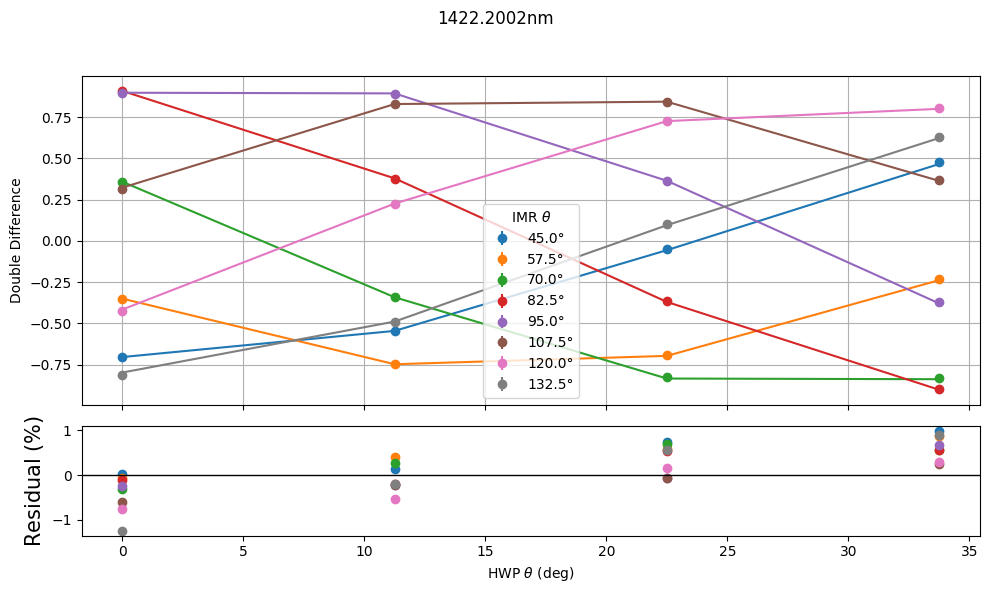

Updated Mueller Matrix:
[[ 2.17263901e-01  2.17263871e-01 -1.14214144e-04  0.00000000e+00]
 [-2.08783190e-01 -2.08783161e-01  1.09755892e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -1.2441469577523492 0.9797318084553197
s_res: 0.5419248093965924
Error: [0.00318029]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7981e-03                                    1.44e-04    
       1              2         4.7897e-03      8.44e-06       1.16e-03       1.36e-05    
       2              3         4.7896e-03      9.63e-08       1.37e-04       1.87e-07    
       3              4         4.7896e-03      1.87e-11       1.93e-06       4.17e-11    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 4.7981e-03, final cost 4.7896e-03, first-order optimality 4.17e

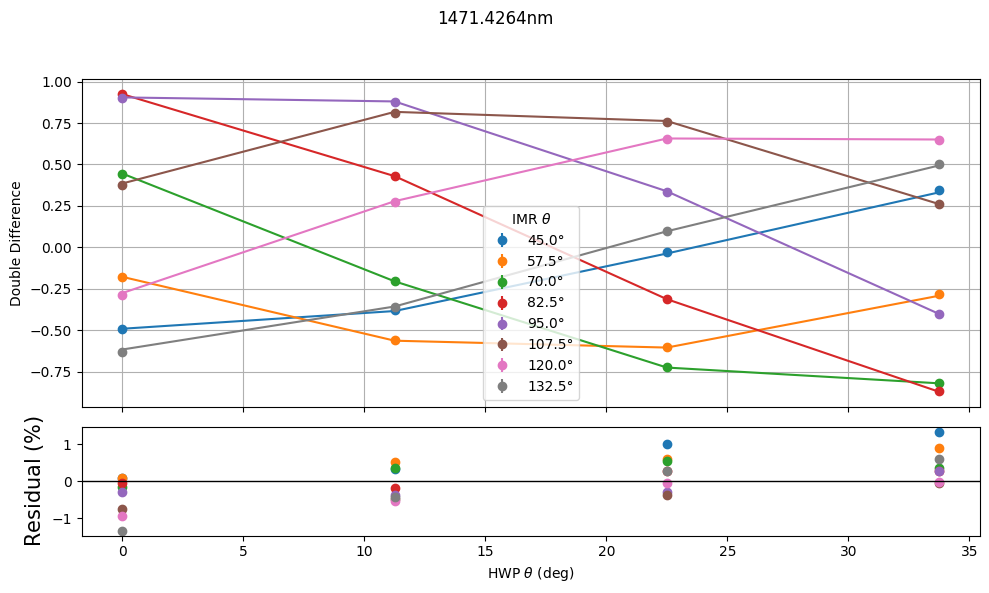

Updated Mueller Matrix:
[[ 2.92615116e-01  2.92615075e-01 -1.53825761e-04  0.00000000e+00]
 [-2.85762165e-01 -2.85762125e-01  1.50223211e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -1.3427868960507752 1.341785637767444
s_res: 0.5717892898774016
Error: [0.0038892]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8510e-03                                    2.55e-04    
       1              2         5.8242e-03      2.68e-05       2.11e-03       3.74e-05    
       2              3         5.8233e-03      8.79e-07       4.37e-04       1.61e-06    
       3              4         5.8233e-03      1.79e-09       2.06e-05       3.56e-09    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 5.8510e-03, final cost 5.8233e-03, first-order optimality 3.56e-0

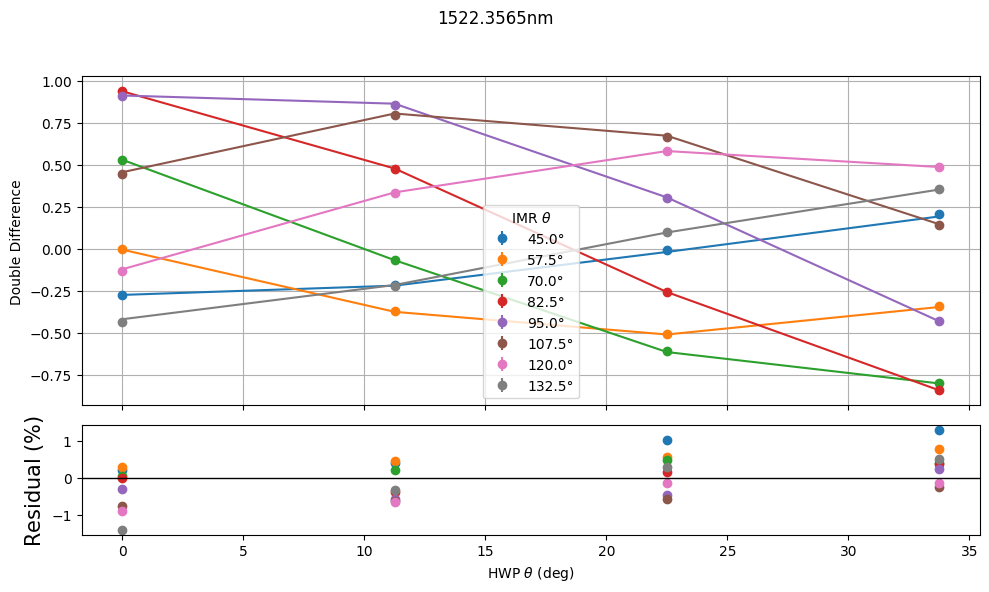

Updated Mueller Matrix:
[[ 3.70118670e-01  3.70118619e-01 -1.94568848e-04  0.00000000e+00]
 [-3.64283249e-01 -3.64283199e-01  1.91501208e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -1.3998203187700469 1.294126704886935
s_res: 0.585728669824372
Error: [0.00468872]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.3102e-03                                    2.17e-05    
       1              2         4.3098e-03      3.66e-07       3.01e-04       6.85e-07    
       2              3         4.3098e-03      3.91e-10       1.02e-05       7.79e-10    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 4.3102e-03, final cost 4.3098e-03, first-order optimality 7.79e-10.
     message: `gtol` termination condition is satisfied.
     success: True
      status

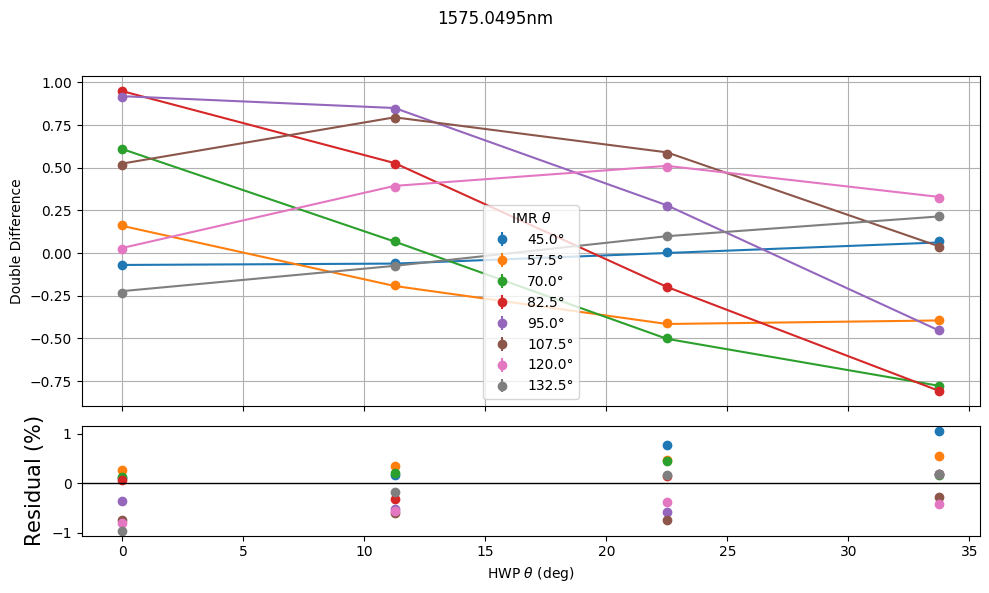

Updated Mueller Matrix:
[[ 4.42357035e-01  4.42356974e-01 -2.32544061e-04  0.00000000e+00]
 [-4.37386931e-01 -4.37386871e-01  2.29931312e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.9576259151865365 1.056724787843737
s_res: 0.49087030622350186
Error: [0.00425658]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.2663e-03                                    2.83e-04    
       1              2         5.2663e-03      5.52e-09       3.86e-05       1.01e-08    
       2              3         5.2663e-03      1.56e-17       1.39e-09       1.15e-09    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 5.2663e-03, final cost 5.2663e-03, first-order optimality 1.15e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      stat

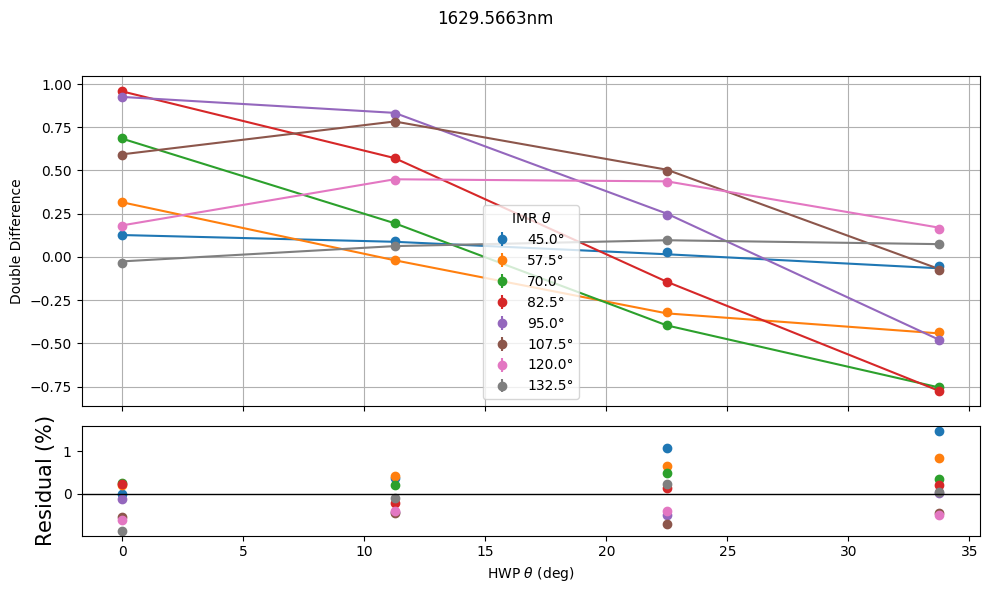

Updated Mueller Matrix:
[[ 5.12976640e-01  5.12976569e-01 -2.69668304e-04  0.00000000e+00]
 [-5.07931800e-01 -5.07931729e-01  2.67016266e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.8755880286304394 1.4877122860435898
s_res: 0.5384003948415109
Error: [0.00475754]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.1171e-03                                    1.52e-02    
       1              2         5.1019e-03      1.52e-05       1.98e-03       3.02e-05    
       2              3         5.1019e-03      6.04e-11       3.95e-06       1.61e-10    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 5.1171e-03, final cost 5.1019e-03, first-order optimality 1.61e-10.
     message: `gtol` termination condition is satisfied.
     success: True
      stat

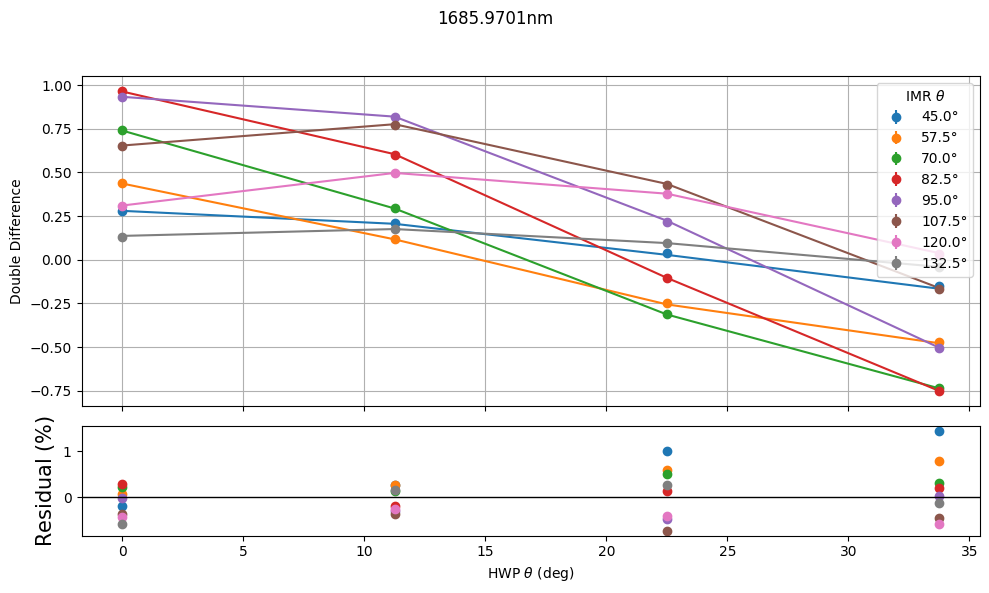

Updated Mueller Matrix:
[[ 5.67902433e-01  5.67902355e-01 -2.98542417e-04  0.00000000e+00]
 [-5.63103773e-01 -5.63103696e-01  2.96019794e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.7344798618231749 1.4528463385760197
s_res: 0.4911974356067082
Error: [0.00457467]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6900e-03                                    1.82e-02    
       1              2         1.6697e-03      2.03e-05       2.22e-03       4.05e-05    
       2              3         1.6697e-03      1.01e-10       4.96e-06       1.54e-10    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.6900e-03, final cost 1.6697e-03, first-order optimality 1.54e-10.
     message: `gtol` termination condition is satisfied.
     success: True
      stat

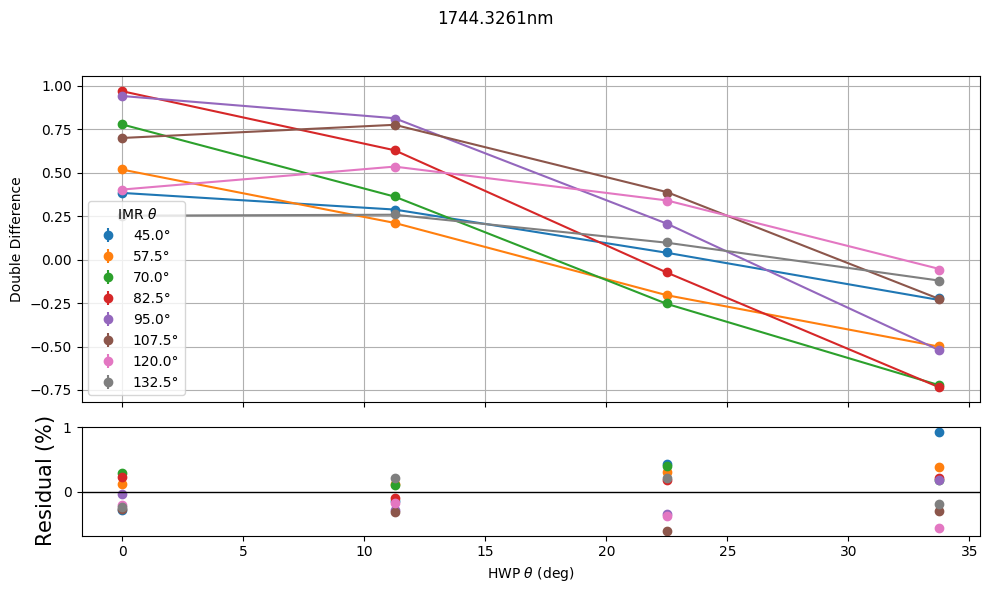

Updated Mueller Matrix:
[[ 6.03872257e-01  6.03872174e-01 -3.17451507e-04  0.00000000e+00]
 [-6.00068728e-01 -6.00068645e-01  3.15452018e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.6100749132763639 0.929933044529502
s_res: 0.33351082741504184
Error: [0.00253641]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4910e-03                                    2.77e-02    
       1              2         1.4465e-03      4.45e-05       3.18e-03       8.85e-05    
       2              3         1.4465e-03      4.57e-10       1.02e-05       9.16e-10    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.4910e-03, final cost 1.4465e-03, first-order optimality 9.16e-10.
     message: `gtol` termination condition is satisfied.
     success: True
      stat

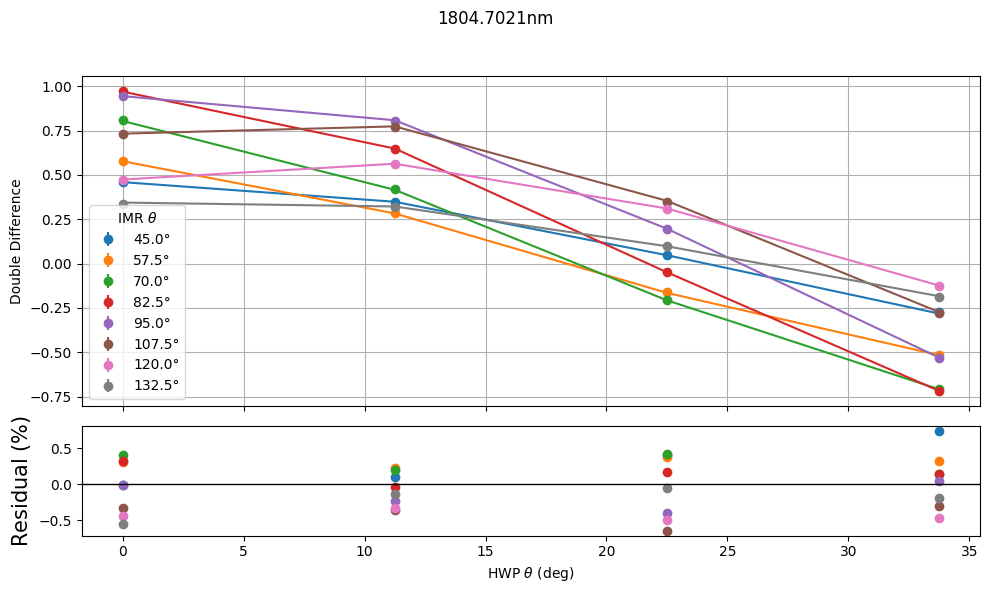

Updated Mueller Matrix:
[[ 6.30175987e-01  6.30175900e-01 -3.31279197e-04  0.00000000e+00]
 [-6.26039724e-01 -6.26039638e-01  3.29104793e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.6494226432899026 0.7453830033742719
s_res: 0.34998334397487185
Error: [0.00228881]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.6427e-03                                    3.71e-02    
       1              2         6.5679e-03      7.48e-05       3.99e-03       1.48e-04    
       2              3         6.5679e-03      1.21e-09       1.61e-05       1.98e-09    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 6.6427e-03, final cost 6.5679e-03, first-order optimality 1.98e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      sta

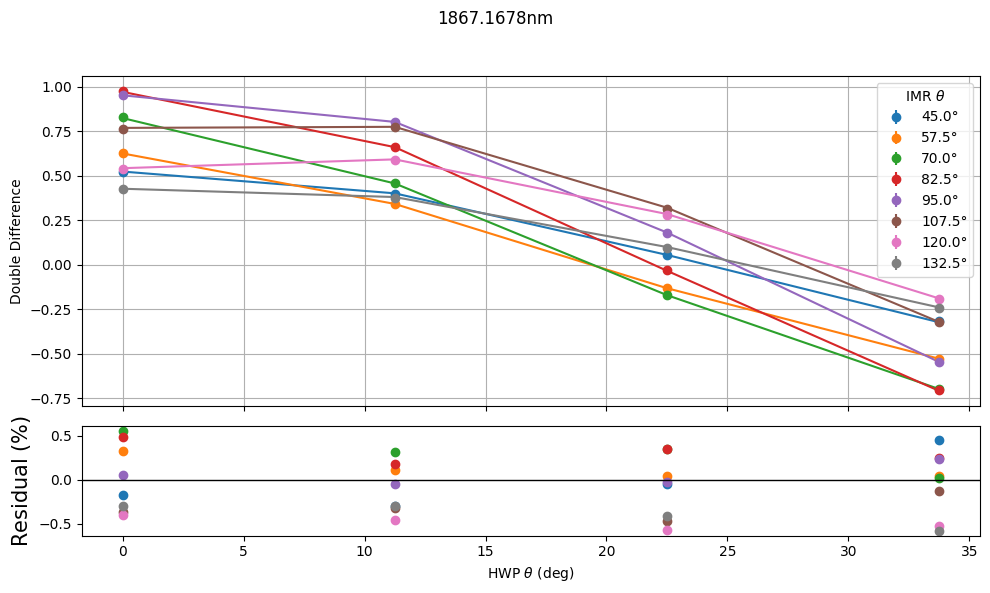

Updated Mueller Matrix:
[[ 6.51943252e-01  6.51943161e-01 -3.42722099e-04  0.00000000e+00]
 [-6.48024428e-01 -6.48024338e-01  3.40662000e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.5784809791559269 0.5555449197870956
s_res: 0.34080055665817505
Error: [0.00472876]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1353e-02                                    4.19e-02    
       1              2         1.1261e-02      9.20e-05       4.34e-03       1.82e-04    
       2              3         1.1261e-02      1.76e-09       1.90e-05       4.56e-09    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.1353e-02, final cost 1.1261e-02, first-order optimality 4.56e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      sta

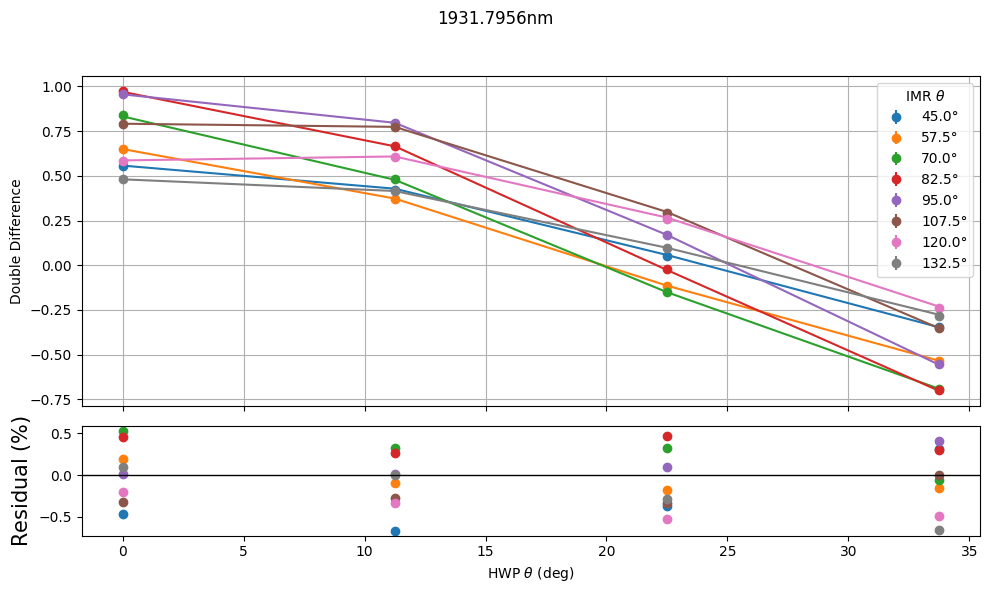

Updated Mueller Matrix:
[[ 6.64245302e-01  6.64245210e-01 -3.49189203e-04  0.00000000e+00]
 [-6.60167796e-01 -6.60167705e-01  3.47045686e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.6694655527790374 0.5325762303791066
s_res: 0.3482430331871711
Error: [0.00607096]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4037e-02                                    4.23e-02    
       1              2         1.3945e-02      9.14e-05       4.28e-03       1.81e-04    
       2              3         1.3945e-02      1.69e-09       1.85e-05       3.54e-09    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.4037e-02, final cost 1.3945e-02, first-order optimality 3.54e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      stat

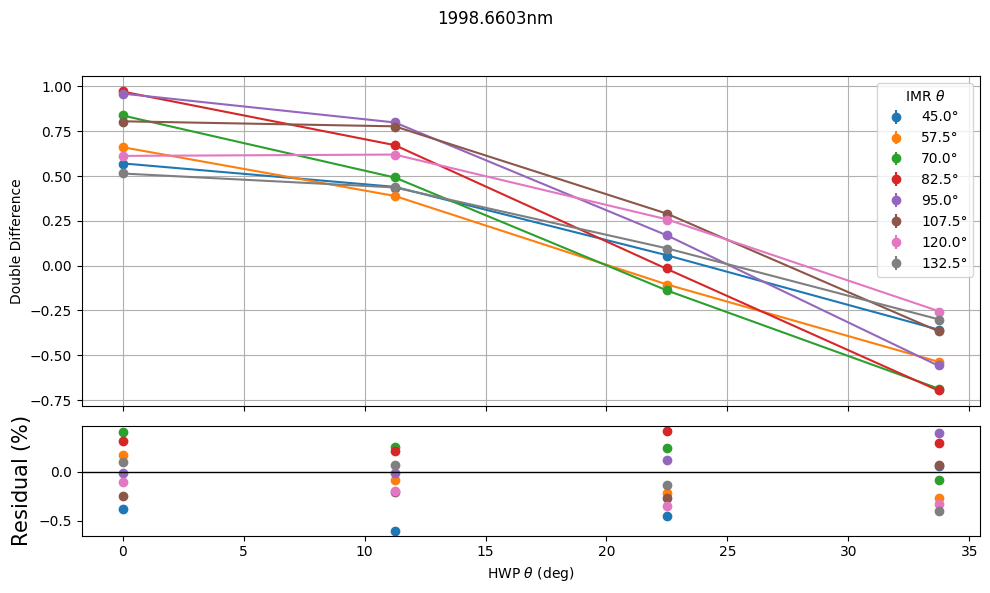

Updated Mueller Matrix:
[[ 6.68810139e-01  6.68810047e-01 -3.51588906e-04  0.00000000e+00]
 [-6.65577529e-01 -6.65577437e-01  3.49889545e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.5993574100371077 0.4134821184230164
s_res: 0.2763545851767395
Error: [0.00668772]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3200e-02                                    3.23e-02    
       1              2         1.3147e-02      5.30e-05       3.24e-03       1.05e-04    
       2              3         1.3147e-02      5.67e-10       1.06e-05       6.09e-10    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.3200e-02, final cost 1.3147e-02, first-order optimality 6.09e-10.
     message: `gtol` termination condition is satisfied.
     success: True
      stat

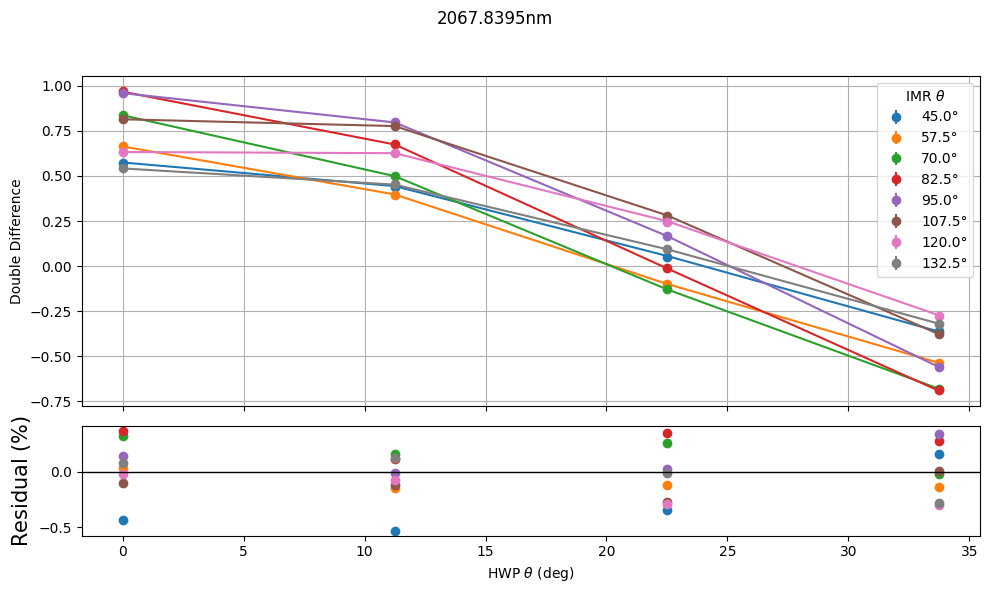

Updated Mueller Matrix:
[[ 6.70703289e-01  6.70703197e-01 -3.52584123e-04  0.00000000e+00]
 [-6.66396767e-01 -6.66396675e-01  3.50320213e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.5312112478434798 0.3698971017449111
s_res: 0.23616274727682754
Error: [0.00644185]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5708e-02                                    2.72e-02    
       1              2         1.5671e-02      3.74e-05       2.71e-03       7.43e-05    
       2              3         1.5671e-02      2.81e-10       7.45e-06       1.16e-09    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.5708e-02, final cost 1.5671e-02, first-order optimality 1.16e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      sta

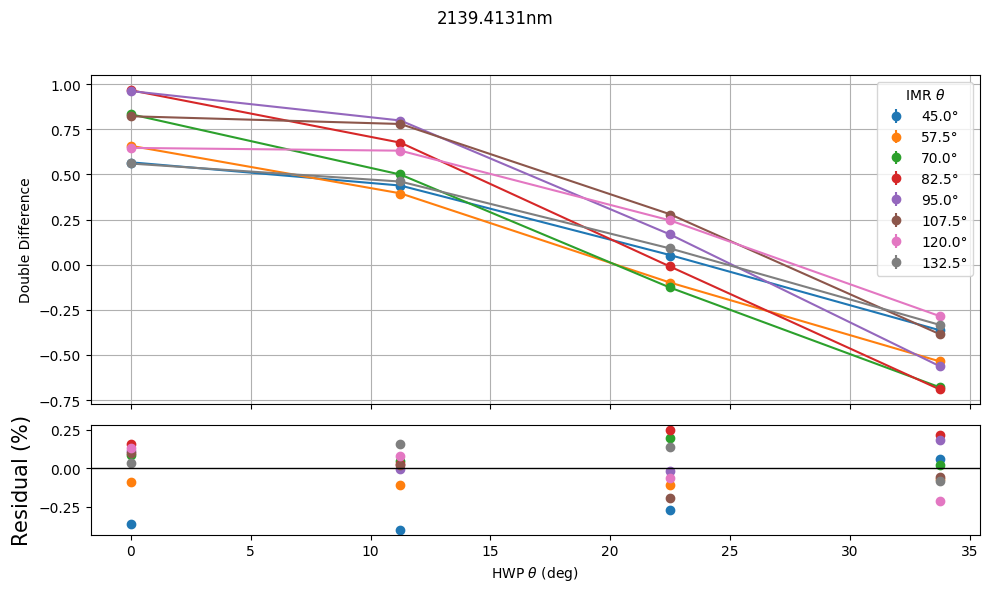

Updated Mueller Matrix:
[[ 6.68562515e-01  6.68562422e-01 -3.51458732e-04  0.00000000e+00]
 [-6.64459382e-01 -6.64459290e-01  3.49301743e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.3995241068905173 0.24950604619874672
s_res: 0.1618682864201691
Error: [0.00701956]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6849e-02                                    2.88e-02    
       1              2         1.6806e-02      4.25e-05       2.90e-03       8.46e-05    
       2              3         1.6806e-02      3.69e-10       8.57e-06       2.16e-09    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.6849e-02, final cost 1.6806e-02, first-order optimality 2.16e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      sta

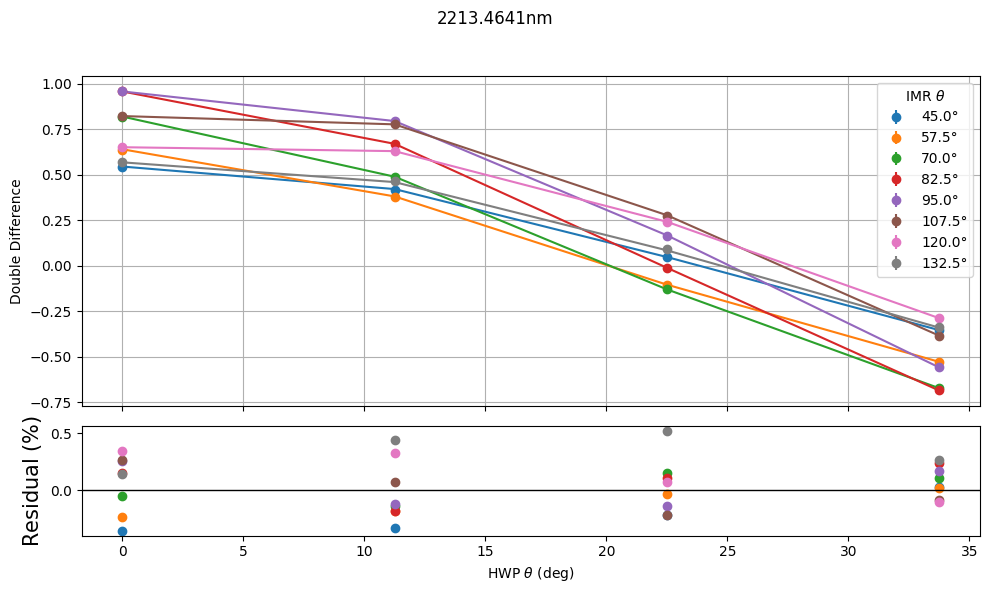

Updated Mueller Matrix:
[[ 6.62148585e-01  6.62148494e-01 -3.48086973e-04  0.00000000e+00]
 [-6.56051301e-01 -6.56051210e-01  3.44881673e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.356943161051575 0.5218166339036294
s_res: 0.22782762020643738
Error: [0.00728704]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5983e-02                                    6.00e-02    
       1              2         1.5794e-02      1.89e-04       6.13e-03       3.73e-04    
       2              3         1.5794e-02      7.38e-09       3.86e-05       1.51e-08    
       3              4         1.5794e-02      1.39e-17       1.56e-09       1.72e-11    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 1.5983e-02, final cost 1.5794e-02, first-order optimality 1.72e

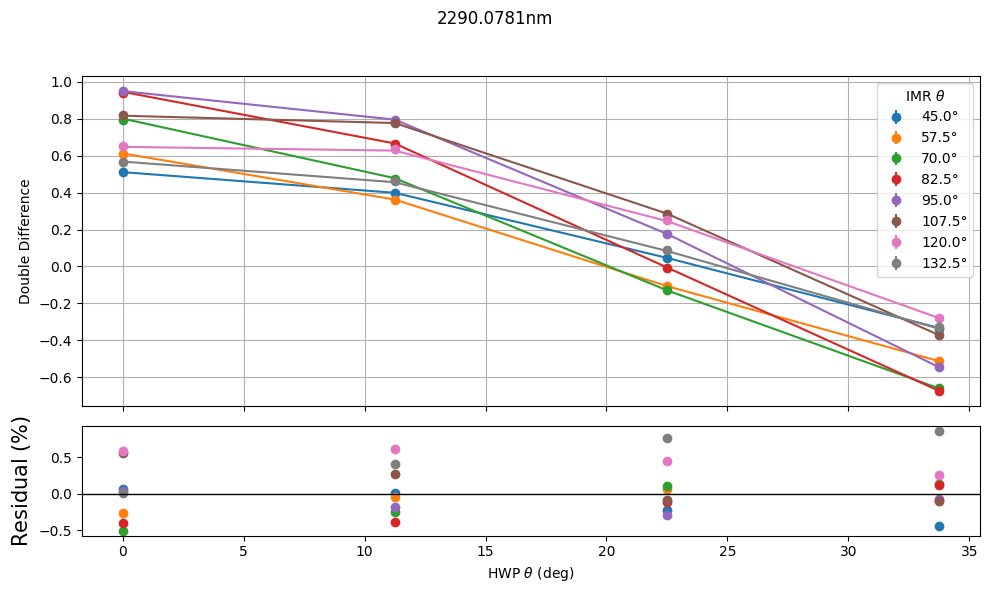

Updated Mueller Matrix:
[[ 6.49880938e-01  6.49880848e-01 -3.41637955e-04  0.00000000e+00]
 [-6.41070106e-01 -6.41070018e-01  3.37006161e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.5057537301476316 0.8588831740327763
s_res: 0.3588904575204761
Error: [0.00710921]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9409e-02                                    1.57e-01    
       1              2         1.8075e-02      1.33e-03       1.62e-02       2.58e-03    
       2              3         1.8074e-02      3.75e-07       2.77e-04       7.49e-07    
       3              4         1.8074e-02      3.17e-14       8.05e-08       1.06e-09    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 1.9409e-02, final cost 1.8074e-02, first-order optimality 1.06e

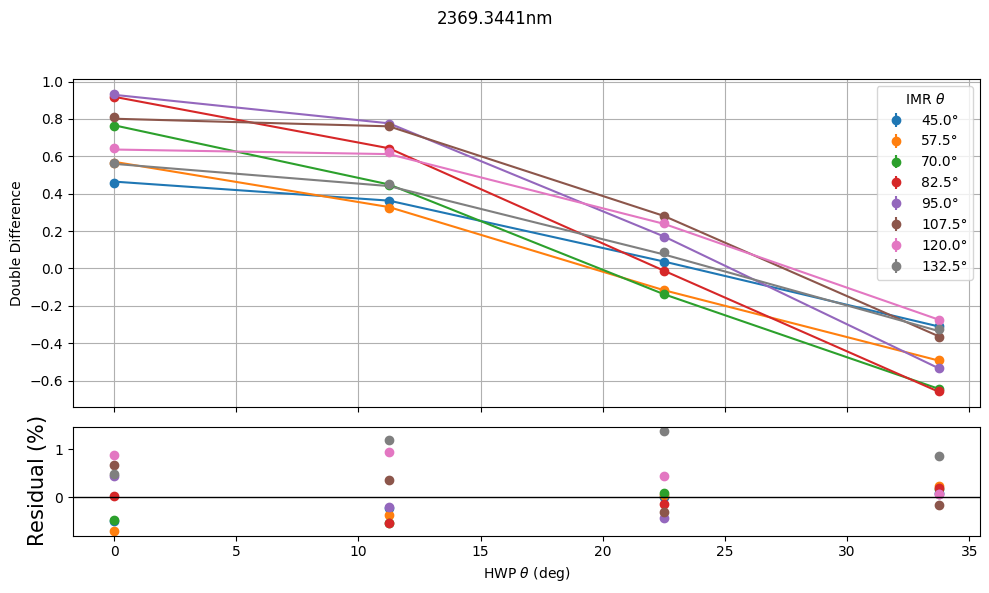

Updated Mueller Matrix:
[[ 6.36608179e-01  6.36608091e-01 -3.34660557e-04  0.00000000e+00]
 [-6.19585603e-01 -6.19585518e-01  3.25711905e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
128 64
Residuals range: -0.6984273468425855 1.3709967031875108
s_res: 0.5436388564819751
Error: [0.00765904]


In [ ]:
from pyPolCal.instruments import fit_CHARIS_Mueller_matrix_by_bin_nbs
from pathlib import Path
errors = []
sres_list = []
for bin in range(0,22):
    error,fig,ax,sres = fit_CHARIS_Mueller_matrix_by_bin_nbs(
        f'../datacsvs/nbs_in_internalcal_csvs/bin{bin}.csv',bin,
        Path(f'../system_dictionaries/nbs_in_internalcal/bin{bin}.json'),
    )
    errors.append(error)
    sres_list.append(sres)



Text(0.5, 1.0, 'Polarimetric Accuracy')

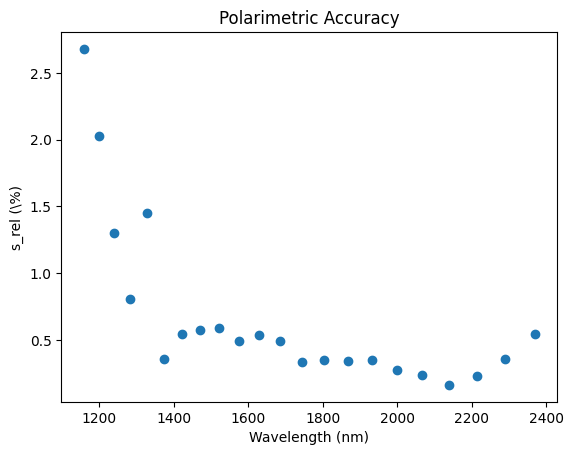

In [2]:
import matplotlib.pyplot as plt
from pyPolCal.constants import wavelength_bins
plt.scatter(wavelength_bins,sres_list)
plt.xlabel('Wavelength (nm)')
plt.ylabel('s_rel (\%)')
plt.title('Polarimetric Accuracy')
#plt.savefig('/home/thomasmc/nbs_in/polcal_testing_2/plots/naive_linear_imr_scipy_physical_hwp_scipy_off.png')